
# LSCP
$$Minimize \sum_{j \in J} x_i $$
$$s.t \sum_{j \in N_i}x_j  \geq 1 \quad for \, all \quad i \in I$$
$$ x_j \in {0,1}  \quad for \, all \quad j \in J$$

|문자|의미|
|-|-|
|i|수요 포인트 index|
|j|설비지역 포인트 index|
|I|수요 포인트 집합|
|J|설비지역 포인트 집합|
|x|설비 후보 지역 중 위치 j 에 설치되면 1, 아니면 0|
|y|적어도 하나의 설비로 그 포인트가 커버되면 1, 아니면 0|

## [공간최적화 참조 코드](https://pysal.org/spaghetti/notebooks/facility-location.html)
## [Geopandas 개발환경 설정](https://hansuho113.tistory.com/22)

## Object
- Location Set Covering Problem
    - 지정된 서비스 반경 내에 있는 고객의 수요를 만족시킬만한 최소한의 개수
- p-median Problem
    - 가중거리를 최소화 시킬 수 있는 미리 결정된 시설 배치
- p-center Problem
    - 최악의 이동거리를 최소화 시킬 수 있는 시설 배치
- Maximal Covering Location Problem
    - 지정된 서비스 반경 중 가장 많은 고객의 수요를 만족시킬만한 시설 배치

# install

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install matplotlib==2.1 -q
!pip install geopandas -q
!pip install libpysal -q
!pip install matplotlib_scalebar -q
!pip install ortools -q
!pip install spaghetti -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 29.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
arviz 0.15.1 requires matplotlib>=3.2, but you have matplotlib 2.1.0 which is incompatible.
bigframes 1.0.0 requires matplotlib>=3.7.1, but you have matplotlib 2.1.0 which is incompatible.
datascience 0.17.6 requires matplotlib>=3.0.0, but you have matplotlib 2.1.0 which is incompatible.
mizani 0.9.3 requires matplotlib>=3.5.0, but you have matplotlib 2.1.0 which is incompatible.
mlxtend 0.22.0 requires matplotlib>=3.0.0, but you have matplotlib 2.1.0 which is incompatible.
plotnine 0.12.4 requires matplotlib>=3.6.0, but you have matplotlib 2.1.0 which is incompatible.
seaborn 0.13.1 requires matplotlib!=3.6.1,>=3.4, but you have matplotlib 2.1.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━

In [ ]:
%config InlineBackend.figure_format = "retina"
import warnings
warnings.filterwarnings(action='ignore') #경고 메시지 무시
from IPython.display import display #print가 아닌 display()로 연속 출력
from IPython.display import HTML #출력 결과를 HTML로 생성

import pandas as pd
from collections import OrderedDict
import geopandas
import libpysal
from libpysal import cg, examples
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
import matplotlib_scalebar
from matplotlib_scalebar.scalebar import ScaleBar
import numpy
import ortools
from ortools.linear_solver import pywraplp
import seaborn
import shapely
from shapely.geometry import Point
import spaghetti
import sys
from pyproj import Proj, transform


%matplotlib inline

import numpy as np
import folium

In [ ]:
import warnings
warnings.filterwarnings(action='ignore') #경고 메시지 무시
from IPython.display import display #print가 아닌 display()로 연속 출력
from IPython.display import HTML #출력 결과를 HTML로 생성

In [ ]:
import pandas as pd
from collections import OrderedDict
import geopandas
import libpysal
from libpysal import cg, examples
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
import matplotlib_scalebar
from matplotlib_scalebar.scalebar import ScaleBar
import numpy
import ortools
from ortools.linear_solver import pywraplp
import seaborn
import shapely
from shapely.geometry import Point
import spaghetti
import sys

%matplotlib inline
import numpy as np
import folium

In [ ]:
try:
    from IPython.display import Markdown as md
except ImportError:
    pass

# Define a Class and functions

In [ ]:
class FacilityLocationModel:
    """Solve a facility location optimization model

    Parameters
    ----------
    name : str
        Problem model name; must also be defined as a class method.
    cij : numpy.ndarray
        cost matrix from origins (index of i) to destination (index of j).
        Default is None.
    ai : numpy.ndarray
        Client weight vector. Default is None.
    s : float
        service radius. Default is None.
    p : int
        Density of facilities to site. Default is None.
    write_lp : str
        file name (and path) of the LP file to write out.
    print_sol : bool
        print select results. Default is True.

    Methods
    -------
    build_lscp : build location set covering problem
    build_pmp : build p-median problem
    build_pcp : build p-center problem
    build_mclp : build maximal covering location problem
    add_vars : add variables to a model
    add_constrs : add contraints to a model
    add_obj : add an objective function to a model
    optimize : solve a model
    record_decisions : record optimal decision variables
    non_obj_vals : record non-objective values stats (eg. percent covered)
    print_results : print selected results

    Attributes
    ----------
    model : ortools.linear_solver.pywraplp.Solver
        proxy of <Swig Object of type 'operations_research::MPSolver *'
    n_cli : int
        total client sites
    r_cli : range
        iterable of client sites
    n_fac : int
        total candidate facility sites
    r_fac : range
        iterable of candidate facility sites
    aij : numpy.ndarray
        binary coverage matrix from cij (within s service radius)
    sij : numpy.ndarray
        demand weighted cost matrix as (ai * cij).
    fac_vars : dict
        facility decision variables
    cli_vars : dict
        client decision variables
    W : ortools.linear_solver.pywraplp.Variable
        minimized maximum variable in the p-center problem formulation
    lp_formulation : str
        linear programming formulation of the model
    solve_minutes : float
        solve time in minutes
    obj_val : int or float
        model objective value
    fac2cli : dict
        facility to client relationship lookup
    cli2fac : dict
        client to facility relationship lookup
    fac2iloc : dict
        facility to dataframe index location lookup
    n_cli_uncov : int
        count of client location outside the service radius
    cli2ncov : dict
        client to covered by count lookup
    ncov2ncli : dict
        covered by count to client count lookup
    mean_dist :
        mean distance per person to the assigned facility
    perc_served :
        percentage of weighted clients covered in `s`
    """

    def __init__(
        self, name, ai=None, cij=None, s=None, p=None, write_lp=None, print_sol=True
    ):
        # Set model information
        self.name = name
        # create a solver instance
        solver_instance = pywraplp.Solver.CBC_MIXED_INTEGER_PROGRAMMING
        # instantiate a model
        self.model = pywraplp.Solver(self.name, solver_instance)

        # Set parameters and indices
        # facility parameter
        if p:
            self.p = p
        # client count and range
        self.cij = cij
        self.n_cli = cij.shape[0]
        self.r_cli = range(self.n_cli)
        # facility count and range
        self.n_fac = self.cij.shape[1]
        self.r_fac = range(self.n_fac)
        # demand parameter
        if ai is not None:
            self.ai = ai
            self.ai_sum = ai.sum()
            # weighted demand
            try:
                self.sij = self.ai * self.cij
            except ValueError:
                self.ai = self.ai.values.reshape(self.n_cli, 1)
                self.sij = self.ai * self.cij
        # if the model has a service radius parameter
        if s:
            self.s = s
            # binary coverage matrix from cij
            self.aij = numpy.zeros(self.cij.shape)
            self.aij[self.cij <= self.s] = 1.0

        # Set decision variables, constraints, and objective function
        try:
            getattr(self, "build_" + self.name)()
        except:
            raise AttributeError(self.name, "not a defined location model.")

        # solve
        self.optimize(write_lp=write_lp)
        # records seleted decision variables
        self.record_decisions()
        # record non-objective values stats (eg. percent covered)
        self.non_obj_vals()
        # print results
        if print_sol:
            self.print_results()

    def build_lscp(self):
        """ Integer programming formulation of the Location Set Covering Problem.
        Originally Published:
            Toregas, C. and ReVelle, Charles. 1972.
            Optimal Location Under Time or Distance Constraints.
            Papers of the Regional Science Association. 28(1):133 - 144.
        """
        # Decision Variables
        self.add_vars()
        # Constraints
        self.add_constrs(constr=1)  # set coverage constraints
        # Objective Function
        self.add_obj()

    def build_pmp(self):
        """Integer programming formulation of the p-median Problem.
        Originally Published:
            S. L. Hakimi. 1964. Optimum Locations of Switching Centers and
            the Absolute Centers and Medians of a Graph. Operations Research.
            12 (3):450-459.
        Adapted from:
                -1-
            ReVelle, C.S. and Swain, R.W. 1970. Central facilities location.
            Geographical Analysis. 2(1), 30-42.
                -2-
            Toregas, C., Swain, R., ReVelle, C., Bergman, L. 1971. The Location
            of Emergency Service Facilities. Operations Research. 19 (6),
            1363-1373.
                - 3 -
            Daskin, M. (1995). Network and discrete location: Models, algorithms,
            and applications. New York: John Wiley and Sons, Inc.
        """
        # Decision Variables
        self.add_vars()
        # Constraints
        self.add_constrs(constr=2)  # assignment constraints
        self.add_constrs(constr=3)  # facility constraint
        self.add_constrs(constr=4)  # opening constraints
        # Objective Function
        self.add_obj()

    def build_pcp(self):
        """Integer programming formulation of the p-center Problem.
        Originally Published:
            S. L. Hakimi. 1964. Optimum Locations of Switching Centers and
            the Absolute Centers and Medians of a Graph. Operations Research.
            12 (3):450-459.
        Adapted from:
            Daskin, M. (1995). Network and discrete location: Models, algorithms,
            and applications. New York: John Wiley and Sons, Inc.
        """
        # Decision Variables
        self.add_vars()
        # Constraints
        self.add_constrs(constr=2)  # assignment constraints
        self.add_constrs(constr=3)  # facility constraint
        self.add_constrs(constr=4)  # opening constraints
        self.add_constrs(constr=5)  # minimized maximum constraints
        # Objective Function
        self.add_obj()

    def build_mclp(self):
        """Integer programming formulation of the Maximal Covering Location Problem.
        Originally Published:
            Church, R. L and C. ReVelle. 1974. The Maximal Covering Location
            Problem. Papers of the Regional Science Association. 32:101-18.
        """
        # Decision Variables
        self.add_vars()
        # Constraints
        self.add_constrs(constr=3)  # facility constraint
        self.add_constrs(constr=6)  # maximal coverage constraints
        # Objective Function
        self.add_obj()

    def add_vars(self):
        """Add variables to a model."""
        # facility decision variables
        self.fac_vars = {j: self.model.IntVar(0, 1, "y[%i]" % (j)) for j in self.r_fac}
        # client decision variables
        if self.name == "mclp":
            self.cli_vars = {
                (i): self.model.IntVar(0, 1, "x[%i]" % (i)) for i in self.r_cli
            }
        if self.name == "pmp" or self.name == "pcp":
            self.cli_vars = {
                (i, j): self.model.IntVar(0, 1, "x[%i,%i]" % (i, j))
                for i in self.r_cli
                for j in self.r_fac
            }
        # minimized maximum variable
        if self.name == "pcp":
            self.W = self.model.NumVar(0, self.model.infinity(), "W")

    def add_constrs(self, constr=None):
        """ Add constraints to a model.
        (1) set coverage constraints
                y1 + x2 >= 1
                x1 + x3 >= 1
                x2 >= 1
        (2) assignment constraints
                x1_1 + x1_2 + x1_3 = 1
        (3) facility constraints
                y1 + y2 + y3 = p
        (4) opening constraints
                - x1_1 + y1 >= 0
                - x2_1 + y1 >= 0
                - x3_1 + y1 >= 0
        (5) minimax constraints
                cost1_1*x1_1 + cost1_2*x1_2 + cost1_3*x1_3 - W <= 0
        (6) maximal coverage constraints
                - x1 + y1 + y3 >= 0
                - x2 + y4 >= 0
        Parameters
        ----------
        constr : int {1, 2, 3, 4, 5, 6}
            Contraint type to add to model. See above for explanation.
            Default is None.
        """
        # 1 - set covering constraints
        if constr == 1:
            for i in self.r_cli:
                self.model.Add(
                    self.model.Sum(
                        [self.aij[i, j] * self.fac_vars[j] for j in self.r_fac]
                    )
                    >= 1
                )
        # 2 - assignment constraints
        elif constr == 2:
            for i in self.r_cli:
                self.model.Add(
                    self.model.Sum([self.cli_vars[i, j] for j in self.r_fac]) == 1
                )
        # 3 - facility constraint
        elif constr == 3:
            self.model.Add(
                self.model.Sum([self.fac_vars[j] for j in self.r_fac]) == self.p
            )
        # 4 - opening constraints
        elif constr == 4:
            for i in self.r_cli:
                for j in self.r_fac:
                    self.model.Add(self.fac_vars[j] - self.cli_vars[i, j] >= 0)
        # 5 - minimax constraints
        elif constr == 5:
            for i in self.r_cli:
                self.model.Add(
                    self.model.Sum(
                        [self.cij[i, j] * self.cli_vars[i, j] for j in self.r_fac]
                    )
                    <= self.W
                )
        # 6 - max coverage constraints
        elif constr == 6:
            for i in self.r_cli:
                self.model.Add(
                    self.model.Sum(
                        [self.aij[i, j] * self.fac_vars[j] for j in self.r_fac]
                    )
                    >= self.cli_vars[i]
                )

    def add_obj(self):
        """Add an objective function to a model."""
        if self.name == "lscp":
            self.model.Minimize(self.model.Sum([self.fac_vars[j] for j in self.r_fac]))

        elif self.name == "pmp":
            obj = [
                self.sij[i, j] * self.cli_vars[i, j]
                for i in self.r_cli
                for j in self.r_fac
            ]
            self.model.Minimize(self.model.Sum(obj))

        elif self.name == "pcp":
            self.model.Minimize(self.W)

        elif self.name == "mclp":
            obj = [self.ai.flatten()[i] * self.cli_vars[i] for i in self.r_cli]
            self.model.Maximize(self.model.Sum(obj))

    def optimize(self, write_lp=False):
        """ Solve the model.
        Parameters
        ----------
        write_lp : bool
            write out the linear programming formulation
        """

        def _redirect_to_file(self, text):
            """ Write out the model in linear programming format.
            Parameters
            ----------
            text : str
                full lp formulation in str format
            """
            original = sys.stdout
            sys.stdout = open(self.name + ".lp", "w")
            print(text)
            sys.stdout = original

        self.model.Solve()
        # linear programming formulation
        if write_lp:
            self.lp_formulation = self.model.ExportModelAsLpFormat(True)
            self._redirect_to_file(self.lp_formulation)
        # WallTime() in milliseconds
        self.solve_minutes = self.model.WallTime() * 1.66667e-5
        self.obj_val = self.model.Objective().Value()

    def record_decisions(self):
        """Record decision variable relationship folowing optimization."""
        # facility-to-dataframe index location lookup
        self.fac2iloc = {v.name(): k for k, v in self.fac_vars.items()}
        # client-to-dataframe index location lookup
        self.cli2iloc = {}
        # facility-to-client lookup
        self.fac2cli = {}

        # record client/service relationships
        for j in self.r_fac:
            if self.fac_vars[j].solution_value() > 0:
                jvar = self.fac_vars[j].name()
                self.fac2cli[jvar] = []
                for i in self.r_cli:
                    ivar = None
                    if self.name == "lscp":
                        if self.aij[i, j] > 0:
                            ivar = "x[%i]" % i
                            self.fac2cli[jvar].append(ivar)
                    elif self.name == "mclp":
                        if self.cli_vars[i].solution_value() > 0:
                            if self.aij[i, j] > 0:
                                ivar = self.cli_vars[i].name()
                                self.fac2cli[jvar].append(ivar)
                    else:
                        if self.cli_vars[i, j].solution_value() > 0:
                            ivar = self.cli_vars[i, j].name()
                            ivar = ivar.split(",")[0] + "]"
                            self.fac2cli[jvar].append(ivar)
                    if ivar:
                        self.cli2iloc[ivar] = i

        # client-to-facility lookup
        self.cli2fac = {}
        for cv in list(self.cli2iloc.keys()):
            self.cli2fac[cv] = []
            for k, v in self.fac2cli.items():
                if cv in v:
                    self.cli2fac[cv].append(k)

        # count of uncovered clients
        self.n_cli_uncov = self.n_cli - len(self.cli2iloc.keys())

        # clients of clients covered by n facilities
        if self.name == "lscp" or self.name == "mclp":
            self.cli2ncov = {}
            for c, fs in self.cli2fac.items():
                self.cli2ncov[c] = len(fs)
            most_coverage = max(self.cli2ncov.values())
            self.ncov2ncli = {}
            for cov_count in range(most_coverage + 1):
                if cov_count == 0:
                    self.ncov2ncli[cov_count] = self.n_cli_uncov
                    continue
                if not cov_count in list(self.cli2ncov.keys()):
                    self.ncov2ncli[cov_count] = 0
                for c, ncov in self.cli2ncov.items():
                    if ncov >= cov_count:
                        self.ncov2ncli[cov_count] += 1

    def non_obj_vals(self):
        """Record non-objective values."""
        if self.name == "pmp":
            self.mean_dist = self.obj_val / float(self.ai_sum)

        if self.name == "mclp":
            self.perc_served = (self.obj_val / float(self.ai_sum)) * 100.0

    def print_results(self):
        """Print select results."""
        print("Solve Time:", self.solve_minutes, "minutes")

        # solve time and objective value
        if self.name == "lscp":
            u1 = "facilities needed for total coverage within a "
            u2 = "%f meter service radius" % self.s
        if self.name == "pmp":
            u1 = "total weighted distance with "
            u2 = "%i selected facilities" % self.p
        if self.name == "pcp":
            u1 = "worst case distance with "
            u2 = "%i selected facilities" % self.p
        if self.name == "mclp":
            u1 = "residents within %f meters of " % self.s
            u2 = "%i selected facilities" % self.p
        units = u1 + u2

        print("Obj. Value:", self.obj_val, units)

        if self.name == "pmp":
            print("Mean weighted distance per", "person: %f" % self.mean_dist)
        if self.name == "mclp":
            print(
                "Percent of %i" % self.ai_sum, "clients covered: %f" % self.perc_served
            )

        # coverage values
        if self.name == "lscp" or self.name == "mclp":
            for ncov, ncli in self.ncov2ncli.items():
                if ncov == 0:
                    print("--- %i clients are not covered" % ncli)
                else:
                    if ncov == 1:
                        sp = "y"
                    else:
                        sp = "ies"
                    print(
                        "--- %i clients are covered" % ncli,
                        "by %i" % ncov,
                        "facilit" + sp,
                    )


In [ ]:
def add_results(model, cli_df, fac_df, print_solution=False):
    """Add decision variable relationships to a dataframe.
    Parameters
    ----------
    model : ortools.linear_solver.pywraplp.Solver
        proxy of <Swig Object of type 'operations_research::MPSolver *'
    cli_df : geopandas.GeoDataFrame
        GeoDataFrame of client locations
    fac_df : geopandas.GeoDataFrame
        GeoDataFrame of facility locations
    print_solution : bool
        print out solution decision variables. Default is False.
    Returns
    -------
    cli_df : geopandas.GeoDataFrame
        updated client locations
    fac_df : geopandas.GeoDataFrame
        updated facility locations
    """
    col_name = model.name + "_sol"
    fillers = [[cli_df, "cli2fac"], [fac_df, "fac2cli"]]
    for df, attr in fillers:
        df[col_name] = df["dv"].map(getattr(model, attr))
        df[col_name].fillna("closed", inplace=True)
    if print_solution:
        selected = fac_df[fac_df[col_name] != "closed"]
        for idx in selected.index:
            print("")
            print(selected.loc[idx, "dv"], "serving:", selected.loc[idx, col_name])
    return cli_df, fac_df

In [ ]:
def plotter(
    fig=None,
    base=None,
    plot_aux=None,
    buffered=None,
    model=None,
    pt1_size=None,
    pt2_size=None,
    plot_res=None,
    save_fig=False,
    title=None,
    figsize=(10, 10),
):
    """ Top-level scenario plotter for location analytics.
    Parameters
    ----------
    fig : matplotlib.figure.Figure
        complete figure to plot. Default is None.
    base : matplotlib.axes._subplots.AxesSubplot
        individual axis to plot. Default is None.
    plot_aux : dict
        model data parameters dataframes to plot keyed by
        descriptive names. Default is None.
    plot_res : dict
        model data results dataframes to plot keyed by
        descriptive names. Default is None.
    buffered : see
        buffer distance from roads segments in `plot_base`.
        Default is None.
    pt1_size : float or float
        size of points to plot. `pt1_size` should always be the
        larger between `pt2_size` and `pt1_size`. Default is None.
    pt2_size : float or float
        size of points to plot. Default is None.
    model : ortools.linear_solver.pywraplp.Solver
        proxy of <Swig Object of type 'operations_research::MPSolver *'
    title : str
        plot title. Default is None.
    figsize : tuple
        Figure size for plot. Default is (12,12).
    save_fig : bool
        Default is False.
    Returns
    -------
    add_to_legend : list
        items to add to legend
    """
    for_multiplot = True
    if not fig and not base:
        for_multiplot = False
        fig, base = plt.subplots(1, 1, figsize=figsize)

    # add title
    if not for_multiplot:
        if model:
            title += " - " + model.name
        base.set_title(title, size=20)
    else:
        base.set_title(model.name, size=20)

    # plot non-results data
    if plot_aux:
        for k, df in plot_aux.items():
            if k == "streets":
                df.plot(ax=base, lw=2, edgecolor="k", zorder=1,color='lavender')
            if k == "buffer":
                df.plot(ax=base, facecolor="y", lw=0.25, alpha=0.25, zorder=1)
            if k == "cli_tru":
                if plot_res:
                    df = df[df[model.name + "_sol"] == "closed"]
                    psize = pt2_size / 6.0
                    pcolor = "k"
                else:
                    n_cli = df.shape[0]
                    psize = pt1_size
                    pcolor = "r"
                df.plot(ax=base, markersize=psize, edgecolor="k", facecolor=pcolor)
            if k == "fac_tru":
                if plot_res:
                    df = df[df[model.name + "_sol"] == "closed"]
                    psize = pt2_size
                    pcolor = "k"
                    pmarker = "*"
                else:
                    n_cli = df.shape[0]
                    psize = pt1_size
                    pcolor = "b"
                    pmarker = "o"
                df.plot(
                    ax=base,
                    markersize=psize,
                    edgecolor="k",
                    facecolor=pcolor,
                    marker=pmarker,
                )
                n_fac = df.shape[0]
            if k == "cli_snp":
                df.plot(
                    ax=base,
                    markersize=pt2_size,
                    edgecolor="k",
                    facecolor="r",
                    alpha=0.75,
                )
            if k == "fac_snp":
                df.plot(
                    ax=base,
                    markersize=pt2_size,
                    edgecolor="k",
                    facecolor="b",
                    alpha=0.75,
                )
        add_to_legend = list(plot_aux.keys())
    else:
        add_to_legend = None

    # plot results data
    if plot_res:
        dv_colors = dv_colorset(plot_res["fac_var"].dv)
        # facilities
        df = plot_res["fac_var"][plot_res["fac_var"][model.name + "_sol"] != "closed"]
        alpha = 1.0 / float(len(df.dv) - 2)
        if alpha > 0.5:
            alpha = 0.5
        # decision variable info for legend
        dvs_to_leg = {}
        # plot facilities
        for dv in df.dv:
            fac = df[df.dv == dv]
            fac.plot(
                ax=base,
                marker="*",
                markersize=pt1_size * 3.0,
                alpha=0.8,
                zorder=3,
                edgecolor="k",
                facecolor=dv_colors[dv],
            )
            # update decision variable info with set color
            dvs_to_leg[dv] = {"facecolor": dv_colors[dv]}
        # plot clients & service areas
        for f, c in model.fac2cli.items():
            fc = plot_res["cli_var"][plot_res["cli_var"].dv.isin(c)]
            fc.plot(
                ax=base,
                markersize=50,
                edgecolor="k",
                facecolor=dv_colors[f],
                alpha=alpha,
                zorder=2,
            )
            # update decision variable info with set client counts
            dvs_to_leg[f].update({"clients": fc.shape[0]})
            # create service area polygon
            service_area = concave_hull(df, fc, f)
            service_area.plot(
                ax=base, edgecolor="k", alpha=0.2, facecolor=dv_colors[f], zorder=1
            )
    else:
        dvs_to_leg = None

    if not model:

        class _ShellModel:
            """Object to mimic `model` when not present."""

            def __init__(self, plot_aux):
                try:
                    self.n_cli = plot_aux["cli_tru"].shape[0]
                    try:
                        self.n_fac = plot_aux["fac_tru"].shape[0]
                    except KeyError:
                        pass
                except KeyError:
                    pass

        try:
            model = _ShellModel(plot_aux)
        except (TypeError, KeyError):
            model = None

    if not for_multiplot:
        # create legend patches
        patches = create_patches(
            model=model,
            for_multiplot=for_multiplot,
            pt1_size=pt1_size,
            pt2_size=pt2_size,
            buffered=buffered,
            legend_aux=add_to_legend,
            dvs_to_leg=dvs_to_leg,
        )
        add_legend(patches, for_multiplot=for_multiplot)
    add_north_arrow(base)
    add_scale(base)

    if save_fig:
        plt.savefig(model.name + ".png")

    # if for a multiplot explicityly return items to add to legend
    if for_multiplot:
        return add_to_legend

In [ ]:
def multi_plotter(
    models,
    plot_aux=None,
    plot_res=None,
    select=None,
    title=None,
    figsize=(14, 14),
    shape=(2, 2),
):
    """plot multiple base axes as one figure
    Parameters
    ----------
    models : list
        solved model objects
    select : dict
        facility-to-selection count lookup.
    shape : tuple
        dimension for subplot array. Default is (2,2).s
    plot_aux : see plotter()
    plot_res : see plotter()
    title : see plotter()
    figsize : see plotter()
    """
    pt1_size, pt2_size = 300, 60
    # convert list of models to array
    mdls = numpy.array(models).reshape(shape)
    fig, axarr = plt.subplots(
        mdls.shape[0], mdls.shape[1], figsize=figsize, sharex="col", sharey="row"
    )
    # add super title to subplot array
    plt.suptitle(title, fontsize=30)
    fig.subplots_adjust(hspace=0.1, wspace=0.005, top=0.925)
    # create each subplot
    for i in range(mdls.shape[0]):
        for j in range(mdls.shape[1]):
            add_to_legend = plotter(
                base=axarr[i, j],
                plot_aux=plot_aux,
                plot_res=plot_res,
                model=mdls[i, j],
                pt1_size=pt1_size,
                pt2_size=pt2_size,
            )
            axarr[i, j].set_aspect("equal")
    add_to_legend = set(add_to_legend)
    # decision variable color set
    dv_colors = dv_colorset(plot_res["fac_var"].dv)
    dvs_to_leg = {f: dv_colors[f] for m in models for f in m.fac2cli.keys()}
    # set ordered dict of {iloc:fac_var, color, x-selected}
    # *** models[0] can be any of the solved models
    dvs_to_leg = {
        models[0].fac2iloc[k]: (k, v, select[k]) for k, v in dvs_to_leg.items()
    }
    dvs_to_leg = OrderedDict(sorted(dvs_to_leg.items()))
    # create legend patches
    patches = create_patches(
        model=None,
        pt1_size=pt1_size,
        pt2_size=pt2_size,
        legend_aux=add_to_legend,
        dvs_to_leg=dvs_to_leg,
        for_multiplot=True,
    )
    add_legend(patches, for_multiplot=True)

In [ ]:
def add_north_arrow(base):
    """add a north arrow to an axes
    Parameters
    ----------
    base : see plotter()
    """
    arw = "rarrow, pad=0.25"
    bbox_props = dict(boxstyle=arw, fc="w", ec="k", lw=2, alpha=0.75)
    base.text(
        221200,
        267200,
        "      z    ",
        bbox=bbox_props,
        fontsize="large",
        fontweight="heavy",
        ha="center",
        va="center",
        rotation=90,
    )

In [ ]:
def add_scale(base):
    """add a scale bar to an axes
    Parameters
    ----------
    base : see plotter()
    """
    scalebar = ScaleBar(1, units="m", location="lower left")
    base.add_artist(scalebar)
    base.set(xticklabels=[], xticks=[], yticklabels=[], yticks=[]);

In [ ]:

def create_patches(
    model=None,
    pt1_size=None,
    pt2_size=None,
    buffered=None,
    legend_aux=None,
    dvs_to_leg=None,
    for_multiplot=False,
):
    """create all patches to add to the legend.
    Parameters
    ----------
    for_multiplot : bool
        for a single plot (True), or multiplot (False).
        Default is False.
    model : see plotter()
    pt1_size : see plotter()
    pt2_size : see plotter()
    buffered : see plotter()
    legend_aux : see plotter()
    dvs_to_leg : see plotter()
    Returns
    -------
    patches : list
        legend handles matching plotted items
    """
    if pt1_size:
        ms1 = float(pt1_size) / 6.0
    if pt2_size:
        ms2 = float(pt2_size) / 8.0
    # streets -- always plot
    strs = mlines.Line2D([], [], color="k", linewidth=2, alpha=1, label="Streets")
    # all patches to add to legend
    patches = [strs]
    # non-results data
    if legend_aux:
        if "buffer" in legend_aux:
            label = "Street buffer (%sm)" % buffered
            strbuff = mpatches.Patch(
                edgecolor="None", facecolor="y", linewidth=2, alpha=0.5, label=label
            )
            patches.append(strbuff)
        if "cli_tru" in legend_aux:
            try:
                if dvs_to_leg:
                    pcolor = "k"
                    msize = ms2 / 3.0
                    plabel = "Uncovered Households " + "($n$=%i)" % model.n_cli_uncov
                else:
                    pcolor = "r"
                    msize = ms1
                    plabel = "Households ($n$=%i)" % model.n_cli
                cli_tru = mlines.Line2D(
                    [],
                    [],
                    color=pcolor,
                    marker="o",
                    ms=msize,
                    linewidth=0,
                    alpha=1,
                    markeredgecolor="k",
                    label=plabel,
                )
                patches.append(cli_tru)
            except AttributeError:
                pass
        if "fac_tru" in legend_aux:
            if dvs_to_leg:
                pcolor = "k"
                msize = ms2
                pmarker = "*"
                no_fac = model.n_fac - len(list(model.fac2cli.keys()))
                plabel = "Unselected Facilities ($n$=%i)" % no_fac
            else:
                pcolor = "b"
                msize = ms1
                pmarker = "o"
                plabel = "Little Free Library candidates" + "($n$=%i)" % model.n_fac
            fac_tru = mlines.Line2D(
                [],
                [],
                color=pcolor,
                marker=pmarker,
                ms=msize,
                markeredgecolor="k",
                linewidth=0,
                alpha=1,
                label=plabel,
            )
            patches.append(fac_tru)
        if "cli_snp" in legend_aux:
            label = "Households snapped to network"
            cli_snp = mlines.Line2D(
                [],
                [],
                color="r",
                marker="o",
                ms=ms2,
                linewidth=0,
                alpha=1,
                markeredgecolor="k",
                label=label,
            )
            patches.append(cli_snp)
        if "fac_snp" in legend_aux:
            label = "LFL candidates snapped to network"
            fac_snp = mlines.Line2D(
                [],
                [],
                color="b",
                marker="o",
                ms=ms2,
                markeredgecolor="k",
                linewidth=0,
                alpha=1,
                label=label,
            )
            patches.append(fac_snp)
    # results data for single plot
    if dvs_to_leg and not for_multiplot:
        # add facility, client, and service area patches to legend
        for k, v in dvs_to_leg.items():
            fdv_label = "Little Free Library %s" % k
            fdv = mlines.Line2D(
                [],
                [],
                color=v["facecolor"],
                marker="*",
                ms=ms1 / 2.0,
                markeredgecolor="k",
                linewidth=0,
                alpha=0.8,
                label=fdv_label,
            )
            cdv_label = "Households served by %s " % k + "($n$=%i)" % v["clients"]
            cdv = mlines.Line2D(
                [],
                [],
                color=v["facecolor"],
                marker="o",
                ms=ms1 / 6.0,
                markeredgecolor="k",
                linewidth=0,
                alpha=0.5,
                label=cdv_label,
            )
            serv_label = "%s service area" % k
            serv = mpatches.Patch(
                edgecolor="k",
                facecolor=v["facecolor"],
                linewidth=2,
                alpha=0.25,
                label=serv_label,
            )
            patches.extend([fdv, cdv, serv])
    # results data for multiplot
    if dvs_to_leg and for_multiplot:
        for idx, (k, v, n) in dvs_to_leg.items():
            fdv = mlines.Line2D(
                [],
                [],
                color=v,
                marker="*",
                ms=ms1 / 2,
                markeredgecolor="k",
                linewidth=0,
                alpha=0.8,
                label="%s ($n$=%i)" % (k, n),
            )
            patches.append(fdv)
    return patches

In [ ]:
def dv_colorset(dvs):
    """decision variables color set
    Parameters
    ---------
    dvs : geopandas.GeoSeries
        facility decision variables
    Returns
    -------
    dv_colors : dict
        decision variable to set color lookup
    """
    dv_colors = [
        "firebrick",
        "silver",
        "mediumseagreen",
        "blueviolet",
        "rebeccapurple",
        "mintcream",
        "snow",
        "cyan",
        "lemonchiffon",
        "limegreen",
        "peachpuff",
        "lightcoral",
        "mediumvioletred",
        "salmon",
        "rebeccapurple",
        "crimson",
        "ivory",
        "lavenderblush",
        "deeppink",
        "darkmagenta",
        "olive",
        "aqua",
        "indigo",
        "cornsilk",
        "cornflowerblue",
        "red",
        "cadetblue",
        'plum',
        'springgreen',
        'dodgerblue',
        'palevioletred',
        'hotpink',
        'darkviolet',
        'mediumslateblue',
        'navy',
        'midnightblue',
        'cornflowerblue',
        'aliceblue',
        'steelblue',
        'darkcyan',
        'teal',
        'darkcyan',
        'azure',
        'aquamarine',
        'mintcream',
    ]


    dv_colors = {dv: dv_colors[idx] for idx, dv in enumerate(dvs)}
    return dv_colors

In [ ]:
def get_buffer(in_data, buff=50):
    """ geopandas.GeoDataFrame should be in a meters projection.
    Parameters
    ----------
    in_data : geopandas.GeoDataFrame
        GeoDataFrame of a shapefile representing a road network.
    buff : int or float
        Desired buffer distance. Default is 50 (meters).
    Returns
    -------
    out_data : geopandas.GeoDataFrame
        Single polygon of the unioned street buffers.
    """
    b1 = in_data.buffer(buff)  # Buffer
    ub = b1.unary_union  # Buffer Union
    b2 = geopandas.GeoSeries(ub)
    out_data = geopandas.GeoDataFrame(b2, crs=in_data.crs, columns=["geometry"])
    return out_data

### 픽셀 사이즈 떄문에 에러 발생시켜서 사용하지 않음
```
def add_legend(patches, for_multiplot=False):
    
    Add a legend to a plot
    Parameters
    ----------
    patches : list
        legend handles matching plotted items
    for_multiplot : create_patches
    
    if for_multiplot:
        anchor = (1.1, 1.65)
    else:
        anchor = (1.005, 1.016)
    legend = plt.legend(
        handles=patches,
        loc="upper left",
        fancybox=True,
        framealpha=0.85,
        bbox_to_anchor=anchor,
        fontsize="x-large",
        labelspacing=1.5,
        borderpad=2.
    )
    legend.get_frame().set_facecolor("white")
```

## Utilizing libpysal.cg.alpha_shapes

In [ ]:
def concave_hull(fac_df, cli_df, f, smoother=10):
    """Create `libpysal.cg.alpha_shape_auto()` object
    for service area representation.
    Parameters
    ----------
    fac_df : geopandas.GeoDataFrame
        GeoDataFrame of facility locations.
    cli_df : geopandas.GeoDataFrame
        GeoDataFrame of client locations.
    f : str
        facility decision variable name.
    smoother : float or int
        buffer (meters). Default is 10.
    Returns
    -------
    ccv :  geopandas.GeoDataFrame
        polygon representing facility service area
    """
    # client location coordinates
    c_array = numpy.array(
        cli_df.geometry.apply(lambda pt: [pt.x, pt.y]).squeeze().tolist()
    )
    # facility location coordinates
    f_array = numpy.array(
        fac_df[fac_df.dv == f].geometry.apply(lambda pt: [pt.x, pt.y]).squeeze()
    )
    # coordinates of all location in the set
    pts_array = numpy.vstack((c_array, f_array))
    # create alpha shape (concave hull)
    ccv = cg.alpha_shape_auto(pts_array, step=4)
    ccv = geopandas.GeoDataFrame([ccv.buffer(smoother)], columns=["geometry"])
    return ccv

In [ ]:
def simulated_geo_points(in_data, needed=20, seed=0, to_file=None):
    """Generate synthetic spatial data points within an area.
    Parameters
    ----------
    in_data : geopandas.GeoDataFrame
        A single polygon of the unioned street buffers.
    needed : int
        Number of points in the buffer. Default is 20.
    seed : int
        Seed for pseudo-random number generation. Default is 0.
    to_file : str
        File name for write out.
    Returns
    -------
    sim_pts : geopandas.GeoDataFrame
        Points within the buffer.
    """
    geoms = in_data.geometry
    area = tuple(in_data.total_bounds)
    simulated_points_list = []
    simulated_points_all = False
    numpy.random.seed(seed)
    while simulated_points_all == False:
        x = numpy.random.uniform(area[0], area[2], 1)
        y = numpy.random.uniform(area[1], area[3], 1)
        point = Point(x, y)
        if geoms.intersects(point)[0]:
            simulated_points_list.append(point)
        if len(simulated_points_list) == needed:
            simulated_points_all = True
    sim_pts = geopandas.GeoDataFrame(
        simulated_points_list, columns=["geometry"], crs=in_data.crs
    )
    if to_file:
        sim_pts.to_file(to_file + ".shp")
    return sim_pts

In [ ]:
def analytics_matrix(mdls):
    """Create stylized dataframe visualization of distance analytics.
    Parameters
    ----------
    mdls : models
        all modeling scenarios
    Returns
    -------
    df : geopandas.GeoDataFrame
        distance analytics matrix
    style : pandas.io.formats.style.Styler
        style dataframe view
    """
    model_names = [m.name for m in mdls]
    boiler = " to assigned facility"
    stats = {
        "abs_min": "Absolute min dist" + boiler,
        "abs_max": "Absolute max dist" + boiler,
        "mean_means": "Mean of mean dists per client" + boiler,
        "mean_stds": "Mean of StD dists per client" + boiler,
    }
    # instantiate dataframe
    df = geopandas.GeoDataFrame()
    df["stats"] = list(stats.keys())
    for n in model_names:
        df[n] = numpy.nan
    # calculate stat for each model
    for m in mdls:
        mins, maxs, stds, means = [], [], [], []
        for f, cs in m.fac2cli.items():
            rows = numpy.array([m.cli2iloc[c] for c in cs])
            col = numpy.array([m.fac2iloc[f]])
            dists = m.cij[rows[:, None], col]
            mins.append(dists.min()), maxs.append(dists.max()),
            stds.append(dists.std()), means.append(dists.mean())
        # fill cells
        calcs = [
            numpy.array(mins).min(),
            numpy.array(maxs).max(),
            numpy.array(means).mean(),
            numpy.array(stds).mean(),
        ]
        label_calc = {k: calcs[idx] for idx, k in enumerate(list(stats.keys()))}
        for k, v in label_calc.items():
            df.loc[(df["stats"] == k), m.name] = v
    # stylize
    cm = seaborn.light_palette("green", as_cmap=True, reverse=True)
    style = df.style.set_caption(stats).background_gradient(
        axis=1, cmap=cm, subset=model_names
    )
    return df, style

In [ ]:
def selection_matrix(mdls):
    """create stylized dataframe visualization of selected decision variables.
    Parameters
    ----------
    mdls : models
        all modeling scenarios
    Returns
    -------
    df : geopandas.GeoDataFrame
        variable selection matrix
    style : pandas.io.formats.style.Styler
        style dataframe view
    """

    def _highlight_membership(s):
        """highlight set membership in pandas.DataFrame."""
        return ["background-color: limegreen" if v == "$\in$" else "" for v in s]

    # set index and coluns in empty dataframe
    var_index = [v.name() for k, v in models[0].fac_vars.items()]
    df = geopandas.GeoDataFrame(index=var_index, columns=[m.name for m in models])
    # if site was selected in a model label with
    # latex symbol for 'element of a set' ($\in$)
    for m in models:
        for f in df.index:
            if f in list(m.fac2cli.keys()):
                df.loc[f, m.name] = "$\in$"
    # label all other cells with latex ($\\notin$)
    df.fillna("$\\notin$", inplace=True)
    for idx in df.index:
        sel = df.loc[idx][df.loc[idx] == "$\in$"].shape[0]
        df.loc[idx, "$\sum$"] = sel
        df.loc[idx, "$\%$"] = (float(sel) / float(4)) * 100.0
    # stylize
    cm = seaborn.light_palette("green", as_cmap=True)
    style = df.style.apply(_highlight_membership).background_gradient(
        cmap=cm, subset=["$\sum$", "$\%$"]
    )
    return df, style


# 좌표 변환 함수 선언
```
#  Projection 정의
# UTM-K
proj_UTMK = Proj(init='epsg:5179') # UTM-K(Bassel) 도로명주소 지도 사용 중

# WGS1984
proj_WGS84 = Proj(init='epsg:4326') # Wgs84 경도/위도, GPS사용 전지구 좌표

# UTM-K -> WGS84 샘플
x1, y1 = 961114.519726,1727112.269174
x2, y2 = transform(proj_UTMK,proj_WGS84,x1,y1)
print(x2,y2)

# WGS84 -> UTM-K 샘플
x1, y1 = 127.07098392510115, 35.53895289091983
x2, y2 = transform(proj_WGS84, proj_UTMK, x1, y1)
print(x2,y2)



#함수화
df_xy = pd.DataFrame([
    ['A', 961114.519726,1727112.269174],
    ['B', 940934.895125,1685175.196487],
    ['C', 1087922.228298,1761958.688262]
], columns=['id', 'x', 'y'])

df_xy[['x_w84', 'y_w84']] = df_xy.apply(transform_utmk_to_w84, axis=1)

```


In [ ]:
from pyproj import Proj, transform
import numpy as np
import pandas  as pd
# UTM-K
proj_UTMK = Proj(init='epsg:5179') # UTM-K(Bassel) 도로명주소 지도 사용 중

# WGS1984
proj_WGS84 = Proj(init='epsg:4326') # Wgs84 경도/위도, GPS사용 전지구 좌표

# x, y 컬럼을 이용하여 UTM-K좌표를 WGS84로 변환한 Series데이터 반환
def transform_utmk_to_w84(df):
    return pd.Series(transform(proj_UTMK, proj_WGS84, df['x'], df['y']), index=['x', 'y'])

def transform_w84_to_utmk(df):
    return pd.Series(transform(proj_WGS84, proj_UTMK, df['x'], df['y']), index=['x', 'y'])


# Geopandas Datape파일

## 서울시 shp

* road = 도로 shape파일

* emd = 읍면동 shape파일

* sig = 시군구 shape파일

In [ ]:
# 도로shp 파일 불러오기
road = geopandas.read_file("/content/drive/MyDrive/Colab Notebooks/강서구 빅데이터 공모전/data/Z_KAIS_TL_SPRD_MANAGE_11.shp",encoding = 'cp949')
#SHP 파일 geometry 좌표변환
road = road.to_crs(epsg=5179)

In [ ]:
road

,ALWNC_DE,ALWNC_RESN,BSI_INT,ENG_RN,MVMN_DE,MVMN_RESN,MVM_RES_CD,NTFC_DE,OPERT_DE,RBP_CN,...,RDS_MAN_NO,REP_CN,RN,RN_CD,ROAD_BT,ROAD_LT,ROA_CLS_SE,SIG_CD,WDR_RD_CD,geometry
0,20100605,용마공원로에서 분기되는 도로구간으로 일련번호부여,8,Yongmagongwon-ro 4-gil,20181213,도로구간변경,12,20100610,20181213150729,망우동 408-1,...,1518,망우동 412-49,용마공원로4길,4118463,2.000,21.000,4,11260,3,"LINESTRING (964726.213 1954952.602, 964745.155..."
1,20100419,중랑천의 옛 이름인 한천에서 유래,10,Hancheon-ro,20100910,"광역도로 정비 및 부여사유, 부여방식 정비",90,20100422,20141030220124,석관동 42-12대,...,409,장위동 311-42 천,한천로,3005038,2.000,11840.000,3,11290,2,"LINESTRING (960997.777 1957395.459, 960994.356..."
2,20100617,경희대로에서 분기된 도로구간으로 순차적으로 일련번호 부여,10,Kyungheedae-ro 1-gil,None,직권수정(속성변경),99,20100617,20190607163749,회기동 16-61,...,5,회기동 60-90,경희대로1길,4115019,6.000,109.000,4,11230,3,"LINESTRING (960427.901 1954796.999, 960440.755..."
3,20100617,홍릉로에서 분기된 도로구간으로 순차적으로 일련번호 부여,10,Hongneung-ro 1ga-gil,None,직권수정(속성변경),99,20100617,20190507100911,제기동 632-20,...,2942,제기동 575-2,홍릉로1가길,4115654,1.000,31.000,4,11230,3,"LINESTRING (959573.096 1953540.645, 959551.422..."
4,20100514,장위로에서 분기되는 도로구간으로 해당 일련번호 부여,10,Jangwi-ro 40-gil,20130528,"광역도로 정비 및 부여사유, 부여방식 정비",90,20100610,20130528203251,장위동 74-5대,...,1560,장위동 66-294대,장위로40길,4121578,5.000,12.000,4,11290,3,"LINESTRING (960456.824 1957174.005, 960459.856..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66954,20230208,수서역세권 공공주택지구 조성사업,20,Jagok-ro 11-gil,20230324,수서역세권 공공주택지구 조성사업,01,20230324,20230324090747,자곡동 100-17,...,7319,자곡동 194-9,자곡로11길,4862412,20.000,750.100,4,11680,3,"LINESTRING (965387.671 1941965.445, 965338.740..."
66955,20230324,수서역세권 공공주택지구 조성사업,20,Jagok-ro 13-gil,20230324,수서역세권 공공주택지구 조성사업,01,20230324,20230324090654,자곡동 123,...,7320,수서동 224-3,자곡로13길,4862411,20.000,1110.120,4,11680,3,"LINESTRING (965595.560 1942048.884, 965561.562..."
66956,20230324,수서역세권 공공주택지구 조성사업,20,Bamgogae-ro 17-gil,20230324,수서역세권 공공주택지구 조성사업,01,20230324,20230324090837,자곡동 323-1,...,7321,자곡동 148-2,밤고개로17길,4862410,20.000,644.940,4,11680,3,"LINESTRING (965104.646 1942336.361, 965191.850..."
66957,20230329,고가도로 신규생성,20,Bongwongogado-ro,20230329,고가도로 신규생성,01,20230329,20230731174900,대신동 143-14,...,4044,신촌동 1-142,봉원고가도로,3354099,14.782,532.200,3,11410,3,"LINESTRING (950972.179 1951771.813, 950995.761..."


In [ ]:
# # 읍면동 시군구 shp 파일 불러오기
emd = geopandas.read_file("/content/drive/MyDrive/Colab Notebooks/강서구 빅데이터 공모전/data/emd/bnd_dong_11160_2023_2023_2Q.shp",encoding = 'utf-8')
sig =  geopandas.read_file("/content/drive/MyDrive/Colab Notebooks/강서구 빅데이터 공모전/data/sig/sig.shp",encoding = 'cp949')
display(emd.head())
display(sig.head())

,BASE_DATE,ADM_NM,ADM_CD,geometry
0,20230701,가양1동,11160640,"POLYGON ((941249.779 1954065.483, 941357.659 1..."
1,20230701,발산1동,11160670,"POLYGON ((940303.513 1951369.243, 940344.902 1..."
2,20230701,공항동,11160690,"POLYGON ((937461.007 1952861.597, 937461.019 1..."
3,20230701,방화1동,11160700,"POLYGON ((939024.136 1953096.145, 939026.797 1..."
4,20230701,방화2동,11160710,"POLYGON ((939006.040 1955916.461, 939033.629 1..."


,SIG_CD,SIG_ENG_NM,SIG_KOR_NM,geometry
0,11110,Jongno-gu,종로구,"POLYGON ((956615.453 1953567.199, 956621.579 1..."
1,11140,Jung-gu,중구,"POLYGON ((957890.386 1952616.746, 957909.908 1..."
2,11170,Yongsan-gu,용산구,"POLYGON ((953115.761 1950834.084, 953114.206 1..."
3,11200,Seongdong-gu,성동구,"POLYGON ((959681.109 1952649.605, 959842.412 1..."
4,11215,Gwangjin-gu,광진구,"POLYGON ((964825.058 1952633.250, 964875.565 1..."


읍면동 내부 도로 경계가 없어서 서울시 도로경계 데이터에서 행정동을 각각 추출해서 행정동별로 도로경계 가져와보기

## 강서구 학교+노인복지시설 clients

* 파일 불러오기
* geodf변환

In [ ]:
fdshop = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/강서구 빅데이터 공모전/data/최종(어린이집포함).csv",encoding = 'cp949')
display(fdshop.head())
fdshop.shape

,이름,행정동,y,x
0,서울공항초등학교병설유치원,방화1동,37.563111,126.821317
1,한나유치원,방화3동,37.576804,126.810287
2,화곡유치원,화곡본동,37.543780,126.846679
3,선미유치원,화곡본동,37.539332,126.843642
4,서울공진초등학교병설유치원,공항동,37.557831,126.822806


(555, 4)

In [ ]:
#가져온 데이터를 좌표계로 변환 후 도로경계와 좌표계 일치시키기위해 5179좌표계로 변환
fdshop = geopandas.GeoDataFrame(fdshop, geometry=geopandas.points_from_xy(fdshop['x'], fdshop['y']))
fdshop.crs = {'init':'epsg:4326'}
fdshop = fdshop.to_crs({'init':'epsg:5179'})
fdshop.head(2)

,이름,행정동,y,x,geometry,dv,weights,mclp_sol
0,서울공항초등학교병설유치원,방화1동,37.563111,126.821317,POINT (940061.312 1951744.452),x[0],1,closed
12,문성유치원,우장산동,37.547022,126.844587,POINT (942104.016 1949944.893),x[1],1,closed


## 단속cctc카메라 facility

In [ ]:
gong = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/강서구 빅데이터 공모전/data/최종 cctv 위경도.csv",encoding = 'cp949')
display(gong.head())
gong.shape

,주소,y,x,행정동,제한속도
0,서울특별시 강서구 방화대로 319,37.569088,126.816603,방화1동,50
1,서울특별시 강서구 공항대로 431,37.555320,126.854341,등촌1동,50
2,서울특별시 강서구 공항동 53-44,37.561314,126.810262,공항동,50
3,서울특별시 강서구 강서로 34,37.530610,126.847404,화곡8동,50
4,서울특별시 강서구 방화동 산 116-9,37.582414,126.818010,방화3동,40


(84, 5)

In [ ]:
#가져온 데이터를 좌표계로 변환 후 도로경계와 좌표계 일치시키기위해 5179좌표계로 변환
gong = geopandas.GeoDataFrame(gong, geometry=geopandas.points_from_xy(gong['x'], gong['y']))
gong.crs = {'init':'epsg:4326'}
gong = gong.to_crs({'init':'epsg:5179'})
gong.head(2)

,주소,y,x,행정동,제한속도,geometry
0,서울특별시 강서구 방화대로 319,37.569088,126.816603,방화1동,50,POINT (939649.816 1952410.624)
1,서울특별시 강서구 공항대로 431,37.555320,126.854341,등촌1동,50,POINT (942971.969 1950859.556)


In [ ]:
idx = gong[gong['주소'] == "서울특별시 강서구 양천로 13"].index
gong.drop(idx , inplace=True)

In [ ]:
idx = gong[gong['주소'] == "서울특별시 강서구 방화대로34길 43"].index
gong.drop(idx , inplace=True)

# 입지모델

## 강서구

### 구추출

* 행정구 코드 베이스로 추출 진행

In [ ]:
road = road[road['SIG_CD'].str.startswith('11500')]

In [ ]:
desired_values = ['방화1동', '발산1동', '우장산동', '염창동']
gong = gong[gong['행정동'].str.contains('|'.join(desired_values))]
fdshop =fdshop[fdshop['행정동'].str.contains('|'.join(desired_values))]

In [ ]:
Gangseo_MH_street= road

In [ ]:
gangseo_clients = fdshop
gangseo_facility = gong

### 수요지, 도로경계 후보지 시각화

<Axes: >

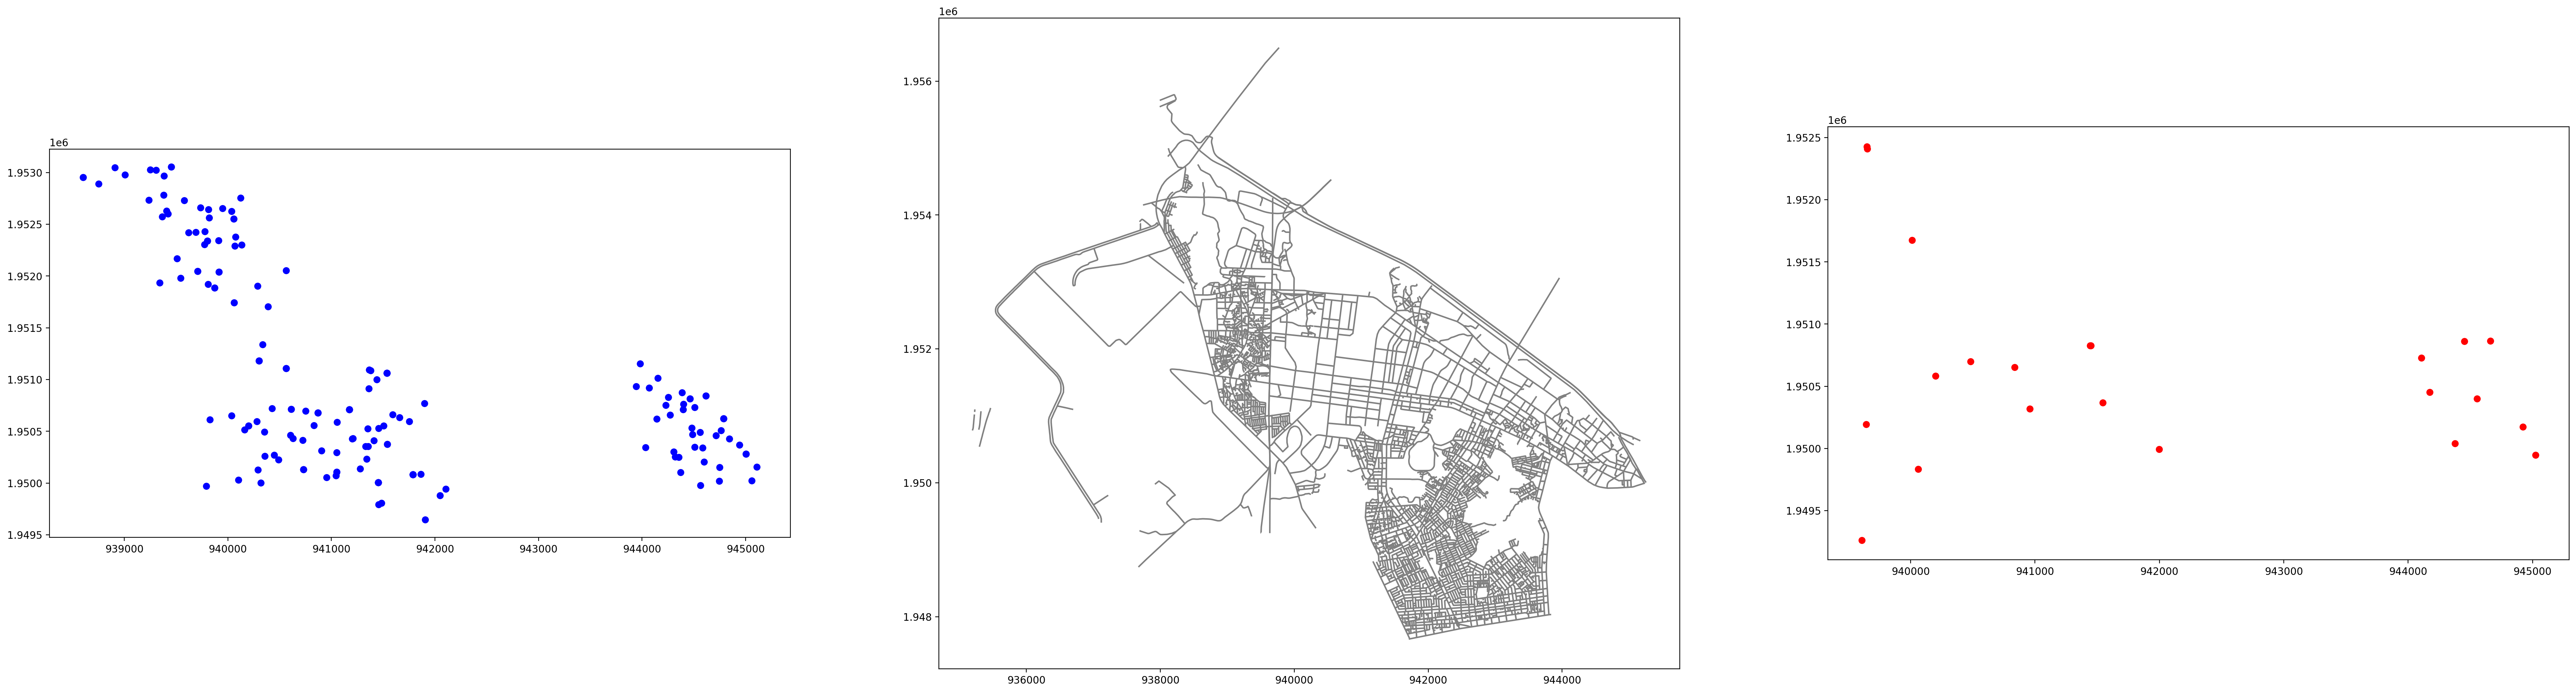

In [ ]:
fig,ax = plt.subplots(1,3,figsize=(45,15))
gangseo_clients.plot(color='blue',ax=ax[0])
Gangseo_MH_street.plot(color='grey',ax=ax[1])
gangseo_facility.plot(color='red',ax=ax[2])

## 세팅

In [ ]:
# 고객수, 필요 설치개수 = x,y
client_count, facility_count = gangseo_clients.shape[0],gangseo_facility.shape[0]


In [ ]:
facility_count

22

In [ ]:
gangseo_streets = Gangseo_MH_street

도로경계 버퍼 범위 설정

In [ ]:
buff = 10
streets_buffer = get_buffer(gangseo_streets, buff=buff)

최종 수요지, 후보지 구분자 삽입

In [ ]:
streets = gangseo_streets
#구분자 삽입
clients = gangseo_clients
clients["dv"] = ["x[%s]" % c for c in range(client_count)]
#구분자 삽입
facilities = gangseo_facility
facilities["dv"] = ["y[%s]" % c for c in range(facility_count)]

display(clients.head())
display(facilities.head())

,이름,행정동,y,x,geometry,dv,weights,mclp_sol
0,서울공항초등학교병설유치원,방화1동,37.563111,126.821317,POINT (940061.312 1951744.452),x[0],1,closed
12,문성유치원,우장산동,37.547022,126.844587,POINT (942104.016 1949944.893),x[1],1,closed
13,우람유치원,방화1동,37.574881,126.814329,POINT (939453.698 1953054.795),x[2],1,"[y[11], y[20]]"
19,방화이화유치원,방화1동,37.574089,126.813528,POINT (939382.325 1952967.466),x[3],1,"[y[11], y[20]]"
24,서울염경초등학교병설유치원,염창동,37.555001,126.871205,POINT (944461.231 1950814.030),x[4],1,[y[12]]


,주소,y,x,행정동,제한속도,geometry,dv
0,서울특별시 강서구 방화대로 319,37.569088,126.816603,방화1동,50,POINT (939649.816 1952410.624),y[0]
8,서울특별시 강서구 방화대로 96,37.549100,126.816695,발산1동,50,POINT (939641.819 1950192.980),y[1]
9,서울특별시 강서구 방화대로 2,37.540704,126.816369,발산1동,50,POINT (939606.249 1949261.691),y[2]
11,서울특별시 강서구 공항대로 653,37.547220,126.877634,염창동,50,POINT (945023.402 1949947.022),y[3]
13,서울특별시 강서구 남부순환로 223,37.545895,126.821464,발산1동,50,POINT (940060.516 1949834.348),y[4]


겹쳐서 시각화

NameError: name 'add_legend' is not defined

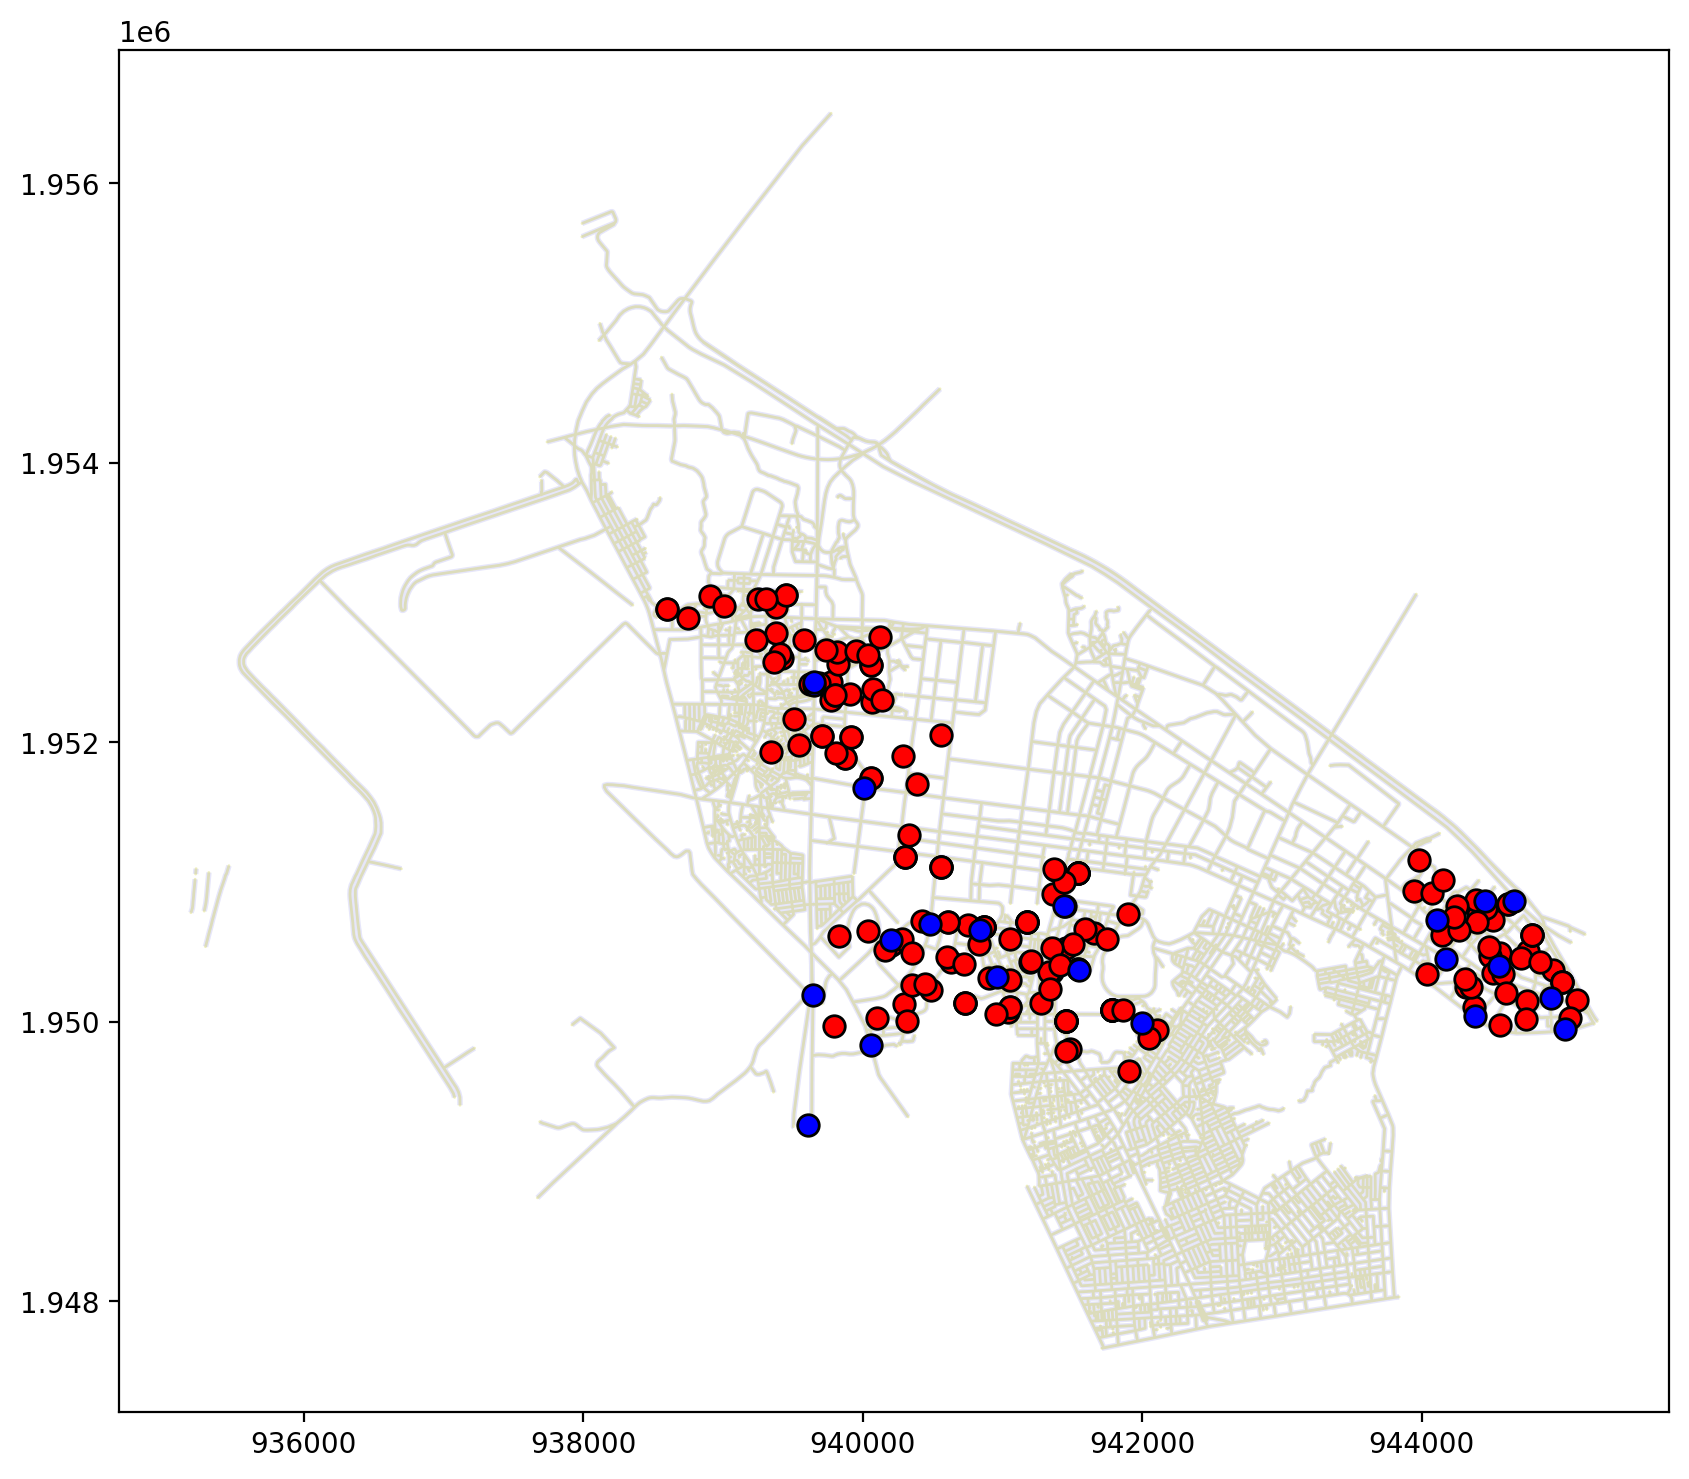

In [ ]:
add_to_plot = {
    "streets": streets,
    "buffer": streets_buffer,
    "cli_tru": clients,
    "fac_tru": facilities,
}

plotter(plot_aux=add_to_plot, buffered=buff, pt1_size=60,figsize=(10,10))

## 모델링

In [ ]:
# 네트워크 불러오기
ntw = spaghetti.Network(in_data=streets)
ntw.snapobservations(clients, "clients", attribute=True)
clients_snapped = spaghetti.element_as_gdf(
    ntw, pp_name="clients", snapped=True
)
ntw.snapobservations(facilities, "facilities", attribute=True)
facilities_snapped = spaghetti.element_as_gdf(
    ntw, pp_name="facilities", snapped=True
)

In [ ]:
# Cost Matrix 계산 시간 소요
cost_matrix = ntw.allneighbordistances(
    sourcepattern=ntw.pointpatterns["clients"],
    destpattern=ntw.pointpatterns["facilities"],
)
cost_matrix[:5,:5]

array([[          inf,           inf,           inf,           inf,
                  inf],
       [4837.24023432, 3600.39086219, 4133.54769812, 3635.36279146,
        3167.06843179],
       [ 918.22505378, 3119.68457422, 4051.14303791, 6945.30478454,
        3617.42425278],
       [ 743.81872154, 2945.27824199, 3876.73670567, 6770.8984523 ,
        3443.01792054],
       [5749.71891501, 6418.3957869 , 6951.55262282, 1320.54919079,
        5985.07335649]])

## mclp

In [ ]:
clients["weights"] = [1]*len(clients)
mclp = FacilityLocationModel(
    "mclp", ai=clients["weights"], cij=cost_matrix, p=5, s=1000)

client, facility = add_results(mclp, clients, facilities)

Solve Time: 0.0022500045 minutes
Obj. Value: 142.0 residents within 1000.000000 meters of 5 selected facilities
Percent of 180 clients covered: 78.888889
--- 38 clients are not covered
--- 142 clients are covered by 1 facility
--- 49 clients are covered by 2 facilities
--- 8 clients are covered by 3 facilities


In [ ]:
facility = facility[facility['mclp_sol'] != 'closed']

In [ ]:
title = "Gangseo-gu Children's Cluster"

NameError: name 'add_legend' is not defined

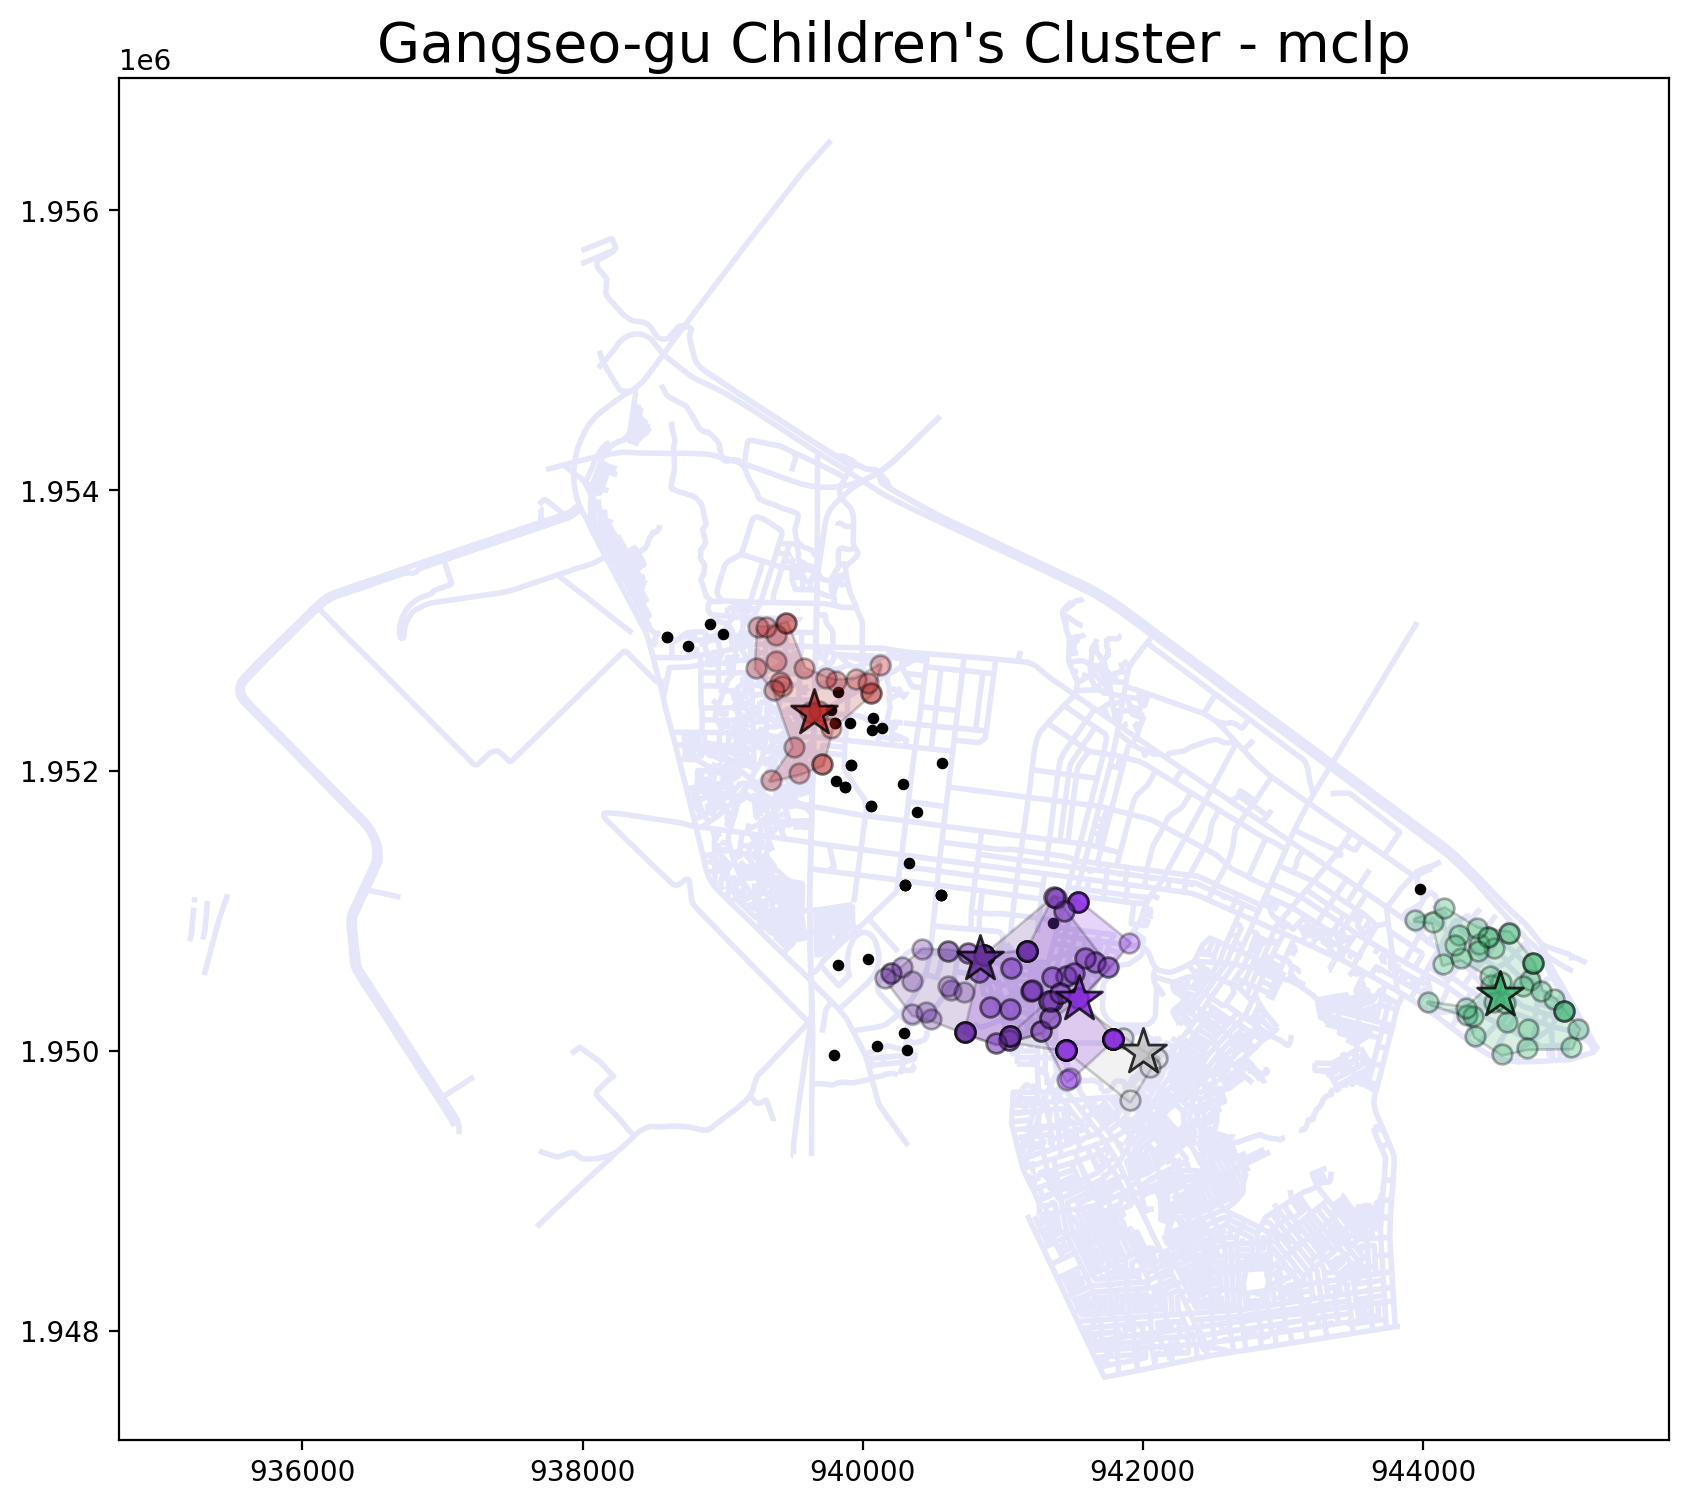

In [ ]:
aux_to_plot = {"streets": streets, "cli_tru": client, "fac_tru": facility}
res_to_plot = {"cli_var": client, "fac_var": facility}
plotter(
    plot_aux=aux_to_plot,
    plot_res=res_to_plot,
    pt1_size=100,
    pt2_size=60,
    model=mclp,
    title=title,
)

In [ ]:
facility

,주소,y,x,행정동,제한속도,geometry,dv,mclp_sol
47,서울특별시 강서구 양천로 13,37.572571,126.805431,방화1동,30,POINT (938666.071 1952804.283),y[11],"[x[2], x[3], x[14], x[30], x[36], x[44], x[55]..."
50,서울특별시 강서구 양천로73길 5,37.551261,126.872277,염창동,30,POINT (944553.181 1950398.498),y[12],"[x[4], x[19], x[20], x[22], x[23], x[24], x[48..."
52,서울특별시 강서구 강서로46길 23,37.550802,126.838218,우장산동,30,POINT (941544.355 1950368.208),y[13],"[x[5], x[6], x[8], x[9], x[10], x[11], x[15], ..."
59,서울특별시 강서구 강서로47길 108,37.553330,126.830169,발산1동,30,POINT (940835.372 1950653.714),y[16],"[x[5], x[7], x[8], x[9], x[13], x[15], x[16], ..."
74,서울특별시 강서구 방화대로 319,37.569244,126.816591,방화1동,50,POINT (939648.882 1952427.939),y[20],"[x[2], x[3], x[26], x[32], x[45], x[55], x[57]..."


In [ ]:
# 모델 평가
models = [mclp]
analytics_df, analytics_display = analytics_matrix(models)
selection_df, selection_display = selection_matrix(models)
display(analytics_display)
display(facilities[facilities["mclp_sol"] != "closed"][["정류소명","dv", "geometry"]])